<a href="https://colab.research.google.com/github/andresvir14/HWDCC_LFTK-/blob/master/HWDCC_LFTK_Final_Proyect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
# Basic libraries
import pandas as pd
import numpy as np

# Preprocesing and feature extraction
from itertools import product
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer

# Modeling
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from xgboost import plot_importance

# Ploting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

# To deal with downloaded files
from google.colab import files

# Others
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Functions used

# Downcast variables 
def downcast(df):
  '''
    Change columns types from 64 to 32 bits
  '''
  float64columns = df.select_dtypes(['float64']).columns.tolist()
  int64columns = df.select_dtypes(['int64']).columns.tolist()
  df[float64columns] = df[float64columns].astype('float32')
  df[int64columns] = df[int64columns].astype('int32')
  return df

# Averages of target variables
def averagevalues(df, group, target):
  '''
  Takes a group of variables (from one two three) and a target variables to return the average 
  '''
  grouped = df.groupby(group).agg({target: ['mean']})
  
  if (len(group) == 1):
    grouped.columns = [group[0]+'_avg_'+target]
  elif (len(group) == 2):
    grouped.columns = [group[0]+'_'+group[1]+'_avg_'+target]
  else:
    grouped.columns = [group[0]+'_'+group[1]+'-'+group[2]+'_avg_'+target]

  grouped.reset_index(inplace=True)
  df = pd.merge(df, grouped, on=group, how='left')
  return df

# Function that creates the lags of given columns
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id', col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+ str(i)]
        shifted['date_block_num'] += i
        shifted[col+'_lag_'+ str(i)] = shifted[col+'_lag_'+ str(i)].astype('float16')
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df    

In [0]:
# Load de the data
transactions    = pd.read_csv('/content/drive/My Drive/DataScience/data/competitive-data-science-predict-future-sales/sales_train.csv')
items           = pd.read_csv('/content/drive/My Drive/DataScience/data/competitive-data-science-predict-future-sales/items.csv')
item_categories = pd.read_csv('/content/drive/My Drive/DataScience/data/competitive-data-science-predict-future-sales/item_categories.csv')
shops           = pd.read_csv('/content/drive/My Drive/DataScience/data/competitive-data-science-predict-future-sales/shops.csv')
transactions_test    = pd.read_csv('/content/drive/My Drive/DataScience/data/competitive-data-science-predict-future-sales/test.csv')


In [0]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in transactions['date_block_num'].unique():
    cur_shops = transactions[transactions['date_block_num']==block_num]['shop_id'].unique()
    cur_items = transactions[transactions['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])), dtype = 'int16'))

# Turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype = np.int32)

# Get aggregated values of sales by shop_id, item_id
gb = transactions.groupby(index_cols).agg({'item_cnt_day':'sum'})
gb.columns = ['target']
gb.reset_index(inplace = True)

# Join aggregated data to the grid and sort the data
train = pd.merge(grid, gb, how='left',on=index_cols).fillna(0)
train['target'] = train['target'].clip(0,20)
train.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

del grid, gb

In [0]:
# Add information from items and shops to train set
train = pd.merge(train, items, on = ['item_id']) # Join item_name and item category
train = pd.merge(train, shops, on = ['shop_id']) # Join shop_name

In [7]:
# Mean encoding with regularization via 5 fold scheme
from sklearn.model_selection import KFold

kf = KFold(5, shuffle = False, random_state = 123)

train['date_block_target_ME'] = 0
#train['shop_target_ME'] = 0
train['item_target_ME'] = 0
train['item_cat_target_ME'] = 0


for tr_ind_ME, val_ind_ME in kf.split(train):
    X_tr_ME, X_val_ME = train.iloc[tr_ind_ME], train.iloc[val_ind_ME]
    
    X_val_ME['date_block_target_ME'] = X_val_ME['date_block_num'].map(X_tr_ME.groupby('date_block_num').target.mean())
 #   X_val_ME['shop_target_ME'] = X_val_ME['shop_id'].map(X_tr_ME.groupby('shop_id').target.mean())
    X_val_ME['item_target_ME'] = X_val_ME['item_id'].map(X_tr_ME.groupby('item_id').target.mean())
    X_val_ME['item_cat_target_ME'] = X_val_ME['item_category_id'].map(X_tr_ME.groupby('item_category_id').target.mean())

    train.iloc[val_ind_ME] = X_val_ME

# Fill nas with the mean of target for all the rows
ME_cols = train.filter(regex=("ME")).columns
train[ME_cols.tolist()] = train[ME_cols.tolist()].fillna(train['target'].mean)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_

In [0]:
# Add itesm and shops to test data
test = pd.merge(transactions_test, items, on = ['item_id']) # Join item_name and item category
test = pd.merge(test, shops, on = ['shop_id']) # Join shop_name

# Set ID as index and join train with test data
test.set_index('ID', inplace = True)
test['date_block_num'] = 34
data = pd.concat([train, test], sort = False)
data = downcast(data)

del items, shops, item_categories, train, test

In [10]:
data.isnull().sum()
#data.tail()

shop_id                      0
item_id                      0
date_block_num               0
target                  214200
item_name                    0
item_category_id             0
shop_name                    0
date_block_target_ME    214200
item_target_ME          214200
item_cat_target_ME      214200
dtype: int64

In [11]:
data.columns

Index(['shop_id', 'item_id', 'date_block_num', 'target', 'item_name',
       'item_category_id', 'shop_name', 'date_block_target_ME',
       'item_target_ME', 'item_cat_target_ME'],
      dtype='object')

In [12]:
# Lagged values
ts = time.time()

data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'target')
data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'date_block_target_ME')
#data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'shop_target_ME')
data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'item_target_ME')
data = lag_feature(data, [1, 2, 3, 4, 5, 12], 'item_cat_target_ME')

data = downcast(data)

time.time() - ts

202.31437182426453

In [0]:
# Drop level one features
data.drop(['date_block_target_ME', 'item_target_ME', 'item_cat_target_ME'], axis = 1, inplace = True) # Drop object columns

In [0]:
# Drop some level variables (lag 0)
data = downcast(data)

In [0]:
data.fillna(0, inplace=True)
data.drop(['item_name', 'shop_name'], axis = 1, inplace = True) # Drop object columns

X_train = data[(data.date_block_num > 11) & (data.date_block_num < 33)].drop(['target'], axis=1)
Y_train = data[(data.date_block_num > 11) & (data.date_block_num < 33)]['target']
X_valid = data[data.date_block_num == 33].drop(['target'], axis=1)
Y_valid = data[data.date_block_num == 33]['target']
X_test = data[data.date_block_num == 34].drop(['target'], axis=1)

del data

In [22]:
ts = time.time()

model = XGBRegressor(
    tree_method = "gpu_hist",
    max_depth = 6, # Tree related parameter: determines how deeply each tree is allowed to grow during any boosting round
    min_child_weight = 600, # 
    colsample_bytree=0.8, # percentage of features used per tree. High value can lead to overfitting
    n_estimators = 500, # number of trees you want to build.
    subsample=0.8, # Boosting parameter: percentage of samples used per tree. Low value can lead to underfitting
    eta=0.3, #  Boosting parameter
    seed=123)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts


[22:37:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.1584	validation_1-rmse:1.1242
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.11709	validation_1-rmse:1.09437
[2]	validation_0-rmse:1.08279	validation_1-rmse:1.07006
[3]	validation_0-rmse:1.05953	validation_1-rmse:1.05099
[4]	validation_0-rmse:1.03794	validation_1-rmse:1.03486
[5]	validation_0-rmse:1.01982	validation_1-rmse:1.02228
[6]	validation_0-rmse:0.999423	validation_1-rmse:1.00936
[7]	validation_0-rmse:0.986333	validation_1-rmse:1.00174
[8]	validation_0-rmse:0.970963	validation_1-rmse:0.993061
[9]	validation_0-rmse:0.961072	validation_1-rmse:0.98713
[10]	validation_0-rmse:0.949588	validation_1-rmse:0.981171
[11]	validation_0-rmse:0.940442	validation_1-rmse:0.976186
[12]	validation_0-rmse:0.932576	v

642.5967996120453

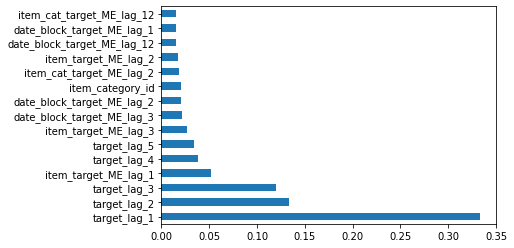

In [23]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [0]:
Y_test = model.predict(X_test).clip(0, 20)
testdata = X_test
testdata['Y_test'] = Y_test

# Add target variable to transactions_test and leave only ID and target
transactions_test.reset_index(inplace = True)
submition = pd.merge(transactions_test, testdata[['shop_id', 'item_id', 'Y_test']], on = ['shop_id', 'item_id'])
submition = submition[['ID', 'Y_test']]
submition.columns = ['ID', 'item_cnt_month']

In [0]:
# Export results
submition.to_csv('V3.csv', index=False)
files.download('V3.csv')

In [0]:
X_train.columns